<a href="https://colab.research.google.com/github/Abhishek-Raj03/Abhishek-Raj03/blob/main/samsumg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=2e3ccc8765d8dae2168905f3b7c36e0f1f231c379c3e719a496c7acdb2250b77
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.7 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [3]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sketch_train8", {}, "train.json", "img")

In [6]:
from detectron2.data import MetadataCatalog

keypoint_names = [
        "nose",
        "left_eye",
        "right_eye",
        "left_ear",
        "right_ear",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"
      ]
keypoint_flip_map = [
        [16, 14],
        [14, 12],
        [17, 15],
        [15, 13],
        [12, 13],
        [6, 12],
        [7, 13],
        [6, 7],
        [6, 8],
        [7, 9],
        [8, 10],
        [9, 11],
        [2, 3],
        [1, 2],
        [1, 3],
        [2, 4],
        [3, 5],
        [4, 6],
        [5, 7]
      ]

from detectron2.data import MetadataCatalog
classes = MetadataCatalog.get("sketch_train8").thing_classes = ["skeleton"]
print(classes)

['skeleton']


In [7]:
MetadataCatalog.get("sketch_train8").thing_classes = ["skeleton"]
MetadataCatalog.get("sketch_train8").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("sketch_train8").keypoint_names = keypoint_names
MetadataCatalog.get("sketch_train8").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("sketch_train8").evaluator_type="coco"

In [9]:
dataset_dicts = DatasetCatalog.get("sketch_train8")
dataset_dicts

[03/25 09:09:52 d2.data.datasets.coco]: Loaded 200 images in COCO format from train.json


[{'file_name': 'img/1.jpg',
  'height': 275,
  'width': 183,
  'image_id': 1,
  'annotations': [{'iscrowd': 0,
    'bbox': [31.3, 21.5, 122.60000000000001, 245.8],
    'keypoints': [49.43323537276948,
     59.39957728703241,
     1,
     45.900675158674915,
     50.92143277320547,
     1,
     53.3190516082735,
     49.15515266615819,
     1,
     44.4876510730371,
     47.388872559110915,
     1,
     68.50906052888008,
     46.32910449488255,
     1,
     67.44929246465173,
     81.30145061441867,
     1,
     100.65535847714058,
     59.752833308441865,
     1,
     68.86231655028955,
     102.49681189898602,
     1,
     127.50281610425922,
     90.13285114965507,
     1,
     53.672307629682955,
     121.9258930765061,
     1,
     145.165617174732,
     128.63775748328575,
     1,
     97.82931030586495,
     154.07219102476657,
     1,
     123.26374384734575,
     157.25149521745166,
     1,
     90.0576778348569,
     195.7564015510824,
     1,
     120.4376956760701,
     199

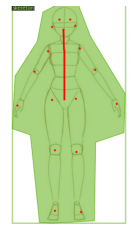

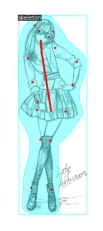

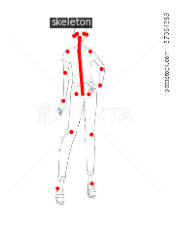

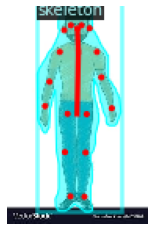

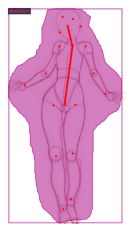

In [16]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer,ColorMode

hands_metadata = MetadataCatalog.get("sketch_train8")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');
# d=dataset_dicts[0]

# while(1):
#     img = cv2.imread(d["file_name"])
#     cv2.imshow('hii',img)
#     visualizer = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=0.5)
# #     if cv2.waitKey(10) & 0xFF == ord('q'):
# #         break
# cv2.destroyAllWindows()
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
#     print(img)
#     cv2.imshow('hii',img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=0.5)   
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sketch_train8",)


#cfg.DATASETS.TEST = ("hand_test",)  #Dataset 'hand_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # hand
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 17
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((17, 1), dtype=float).tolist()


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/25 09:10:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a6e10b.pkl: 237MB [00:01, 195MB/s]                           


[03/25 09:10:20 d2.engine.train_loop]: Starting training from iteration 0


/content/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/content/detectron2/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/na

[03/25 09:10:38 d2.utils.events]:  eta: 0:03:33  iter: 19  total_loss: 8.718  loss_cls: 0.1992  loss_box_reg: 0.132  loss_keypoint: 8.238  loss_rpn_cls: 0.01575  loss_rpn_loc: 0.02239    time: 0.4499  last_time: 0.3444  data_time: 0.0187  last_data_time: 0.0099   lr: 9.7405e-06  max_mem: 2845M
[03/25 09:10:47 d2.utils.events]:  eta: 0:03:36  iter: 39  total_loss: 7.236  loss_cls: 0.1058  loss_box_reg: 0.1019  loss_keypoint: 6.645  loss_rpn_cls: 0.01659  loss_rpn_loc: 0.0176    time: 0.4627  last_time: 0.4790  data_time: 0.0129  last_data_time: 0.0075   lr: 1.9731e-05  max_mem: 2936M
[03/25 09:10:56 d2.utils.events]:  eta: 0:03:28  iter: 59  total_loss: 7.09  loss_cls: 0.09361  loss_box_reg: 0.1318  loss_keypoint: 6.722  loss_rpn_cls: 0.0125  loss_rpn_loc: 0.01077    time: 0.4653  last_time: 0.4811  data_time: 0.0145  last_data_time: 0.0010   lr: 2.972e-05  max_mem: 2936M
[03/25 09:11:06 d2.utils.events]:  eta: 0:03:20  iter: 79  total_loss: 5.731  loss_cls: 0.06579  loss_box_reg: 0.127

In [18]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"

# load the pre trained model from Detectron2 model zoo
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold


def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');


predictor = DefaultPredictor(cfg)
#im = cv2.imread("waving.jpg")
#im = cv2.imread("test.jpeg")
im = cv2.imread("1.jpg")
outputs = predictor(im)
print(outputs)
o = outputs["instances"]
print("###########################################################")



idxofClass = [i for i, x in enumerate(list(outputs['instances'].pred_classes)) if x == 15]

#Create new class, boxes, scores & masks
classes = o.pred_classes[idxofClass]
scores = o.scores[idxofClass]
boxes = o.pred_boxes[idxofClass]
#masks = o.pred_masks[idxofClass]

#Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
obj = detectron2.structures.Instances(image_size=(480, 640))

obj.set('pred_classes', classes)
obj.set('scores', scores)
obj.set('pred_boxes', boxes)
#obj.set('pred_masks', masks)

# out = v.draw_instance_predictions(obj.to("cpu"))

[03/25 09:33:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


backbone.res2.0.conv1.norm.{bias, weight}
backbone.res2.0.conv1.weight
backbone.res2.0.conv2.norm.{bias, weight}
backbone.res2.0.conv2.weight
backbone.res2.0.conv3.norm.{bias, weight}
backbone.res2.0.conv3.weight
backbone.res2.0.shortcut.norm.{bias, weight}
backbone.res2.0.shortcut.weight
backbone.res2.1.conv1.norm.{bias, weight}
backbone.res2.1.conv1.weight
backbone.res2.1.conv2.norm.{bias, weight}
backbone.res2.1.conv2.weight
backbone.res2.1.conv3.norm.{bias, weight}
backbone.res2.1.conv3.weight
backbone.res2.2.conv1.norm.{bias, weight}
backbone.res2.2.conv1.weight
backbone.res2.2.conv2.norm.{bias, weight}
backbone.res2.2.conv2.weight
backbone.res2.2.conv3.norm.{bias, weight}
backbone.res2.2.conv3.weight
backbone.res3.0.conv1.norm.{bias, weight}
backbone.res3.0.conv1.weight
backbone.res3.0.conv2.norm.{bias, weight}
backbone.res3.0.conv2.weight
backbone.res3.0.conv3.norm.{bias, weight}
backbone.res3.0.conv3.weight
backbone.res3.0.shortcut.norm.{bias, weight}
backbone.res3.0.shortcut.w

{'instances': Instances(num_instances=0, image_height=275, image_width=183, fields=[pred_boxes: Boxes(tensor([], size=(0, 4))), scores: tensor([]), pred_classes: tensor([], dtype=torch.int64)])}
###########################################################


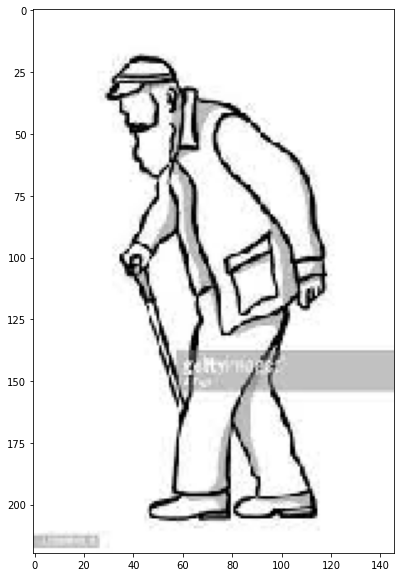

In [19]:
from detectron2.utils.visualizer import Visualizer,ColorMode
v = Visualizer(im[:, :, ::-1],
                   metadata=hands_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()